# **HW 2 Problem 4 - Explainability with ShaRP**

# Explaining lending decisions using ShaRP

When multiple people apply for a loan, banks need to select who to fund. They do so by calculating how likely a person is to repay the loan and then select among the most likely. This process is a ranking process that ShaRP, a tool we saw in the lab, can explain.

To calculate feature importance, we will use ShaRP, a tool we've seen in the lab. For more information about the method, see the [full paper](https://arxiv.org/abs/2401.16744), and for more information about the toolkit see the [documentation](https://dataresponsibly.github.io/ShaRP/).

#1. Import Statements

First we install `ShaRP` and the necessary packages for this problem

In [1]:
# Data
!pip install folktables
# ShaRP
!pip install git+https://github.com/DataResponsibly/ShaRP.git

  Cloning https://github.com/DataResponsibly/ShaRP.git to /tmp/pip-req-build-x7blvegf
  Running command git clone --filter=blob:none --quiet https://github.com/DataResponsibly/ShaRP.git /tmp/pip-req-build-x7blvegf
  Resolved https://github.com/DataResponsibly/ShaRP.git to commit b1583d7ce75fb1dde2f0ab46da6e3edd0b13d21d
  Preparing metadata (setup.py) ... done
  Created wheel for sharp: filename=sharp-0.1.dev0-py3-none-any.whl size=28965 sha256=4beffe1d75ad50d5285f81eb1c20563ee4ae57162bc43c069ff2d4ff369a0772
  Stored in directory: /tmp/pip-ephem-wheel-cache-mu4ebc1a/wheels/a8/77/22/f347a84278c6d9294aefeffe944354bbe6aa605222284e8019
Successfully built sharp


In [2]:
#@markdown Import statments
from folktables import ACSDataSource, ACSIncome

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker

import seaborn as sns

import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sharp import ShaRP
from sharp.utils import scores_to_ordering

#2. Load Data

Next, we will load the ACSIncome dataset from the Folktables benchmark --- this is the same dataset used in Lab 2, 3 and 9.  Folktables is based from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as-is for the following analyses.

## Data profiling

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | (Sensitive Attribute) White=1, Black=2, Other races are between 3 and 9 |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [3]:
#@markdown Import data
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features = ACSIncome.features
target_name = ACSIncome.target
data = acs_data.sample(1000, random_state=39)[features+list([target_name])]

print(data.shape)
data.head()

(1000, 11)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PINCP
123170,40,1.0,12.0,4,9640.0,303,0,40.0,2,8,6300.0
366093,40,3.0,16.0,5,5240.0,316,10,40.0,2,8,36000.0
279966,37,1.0,20.0,5,5000.0,303,5,NaN,2,1,0.0
206601,50,1.0,16.0,1,7700.0,206,1,56.0,1,6,48000.0
96394,26,7.0,19.0,5,7200.0,216,2,50.0,1,1,60000.0


## Preprocessing

Similarly to the explainability lab, we will be working with a limited number of features. We will also preprocess the data by dropping N/A columns and changing the type of features, as we did for this dataset in the labs.

In [4]:
#@markdown Drop rows with missing values
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 123170 to 242250
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGEP    545 non-null    int64  
 1   COW     545 non-null    float64
 2   SCHL    545 non-null    float64
 3   MAR     545 non-null    int64  
 4   OCCP    545 non-null    float64
 5   POBP    545 non-null    int64  
 6   RELP    545 non-null    int64  
 7   WKHP    545 non-null    float64
 8   SEX     545 non-null    int64  
 9   RAC1P   545 non-null    int64  
 10  PINCP   545 non-null    float64
dtypes: float64(5), int64(6)
memory usage: 51.1 KB


In [5]:
# @markdown Count how many people we are ranking
population_size = data.shape[0]
print(population_size)

545


In [6]:
#@markdown Drop non-ordinal and some sensitive categorical features
non_ordinal_categorical_cols = ['COW','MAR','OCCP','POBP','RELP','SEX']
data.drop(columns=non_ordinal_categorical_cols, inplace=True)

In [7]:
#@markdown Change data types of categorical features and sensitive feature we will be using.
# @markdown Note that we will use SCHL as a numerical feature because it's ordinal
numerical_cols = ['AGEP','WKHP', 'SCHL']
categorical_cols = ['RAC1P']

for col in categorical_cols:
  data[col] = data[col].astype('int')
  data[col] = data[col].astype('category')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 545 entries, 123170 to 242250
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   AGEP    545 non-null    int64   
 1   SCHL    545 non-null    float64 
 2   WKHP    545 non-null    float64 
 3   RAC1P   545 non-null    category
 4   PINCP   545 non-null    float64 
dtypes: category(1), float64(3), int64(1)
memory usage: 22.2 KB


In [8]:
#@markdown Standardize numerical features, we will use a min-max scaler because we use linear weighted functions
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data.head()

,AGEP,SCHL,WKHP,RAC1P,PINCP
123170,0.363636,0.478261,0.397959,8,6300.0
366093,0.363636,0.652174,0.397959,8,36000.0
206601,0.515152,0.652174,0.561224,6,48000.0
96394,0.151515,0.782609,0.500000,1,60000.0
232318,0.393939,0.869565,0.500000,9,55000.0


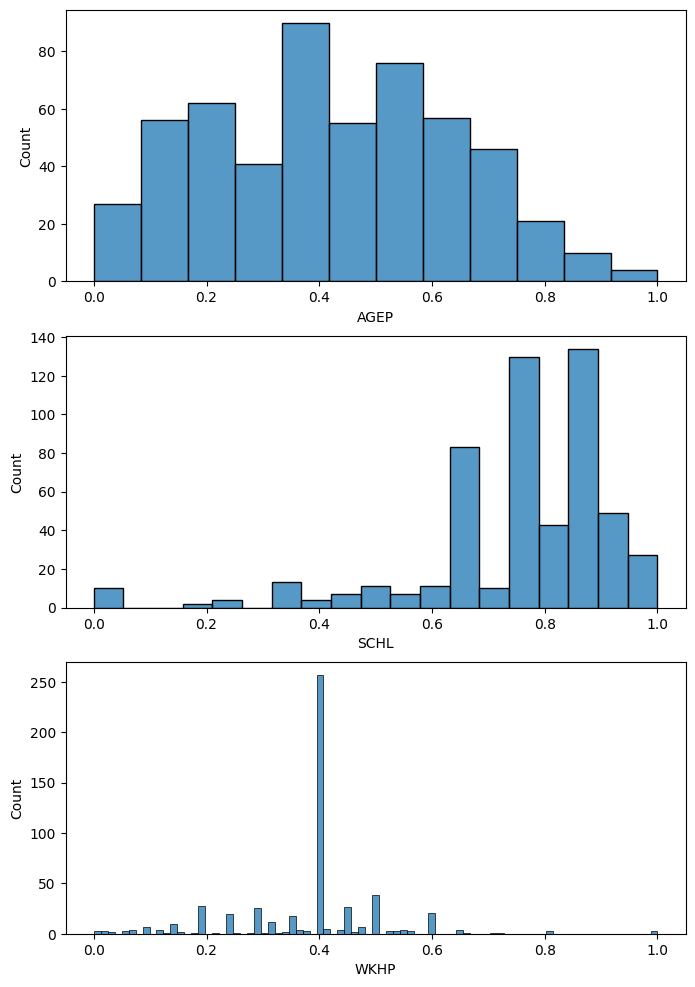

In [9]:
#@markdown Let's see how the distributions look after using the scaler
fig, ax = plt.subplots(3,1,figsize=(8,12))

ax[0] = sns.histplot(data=data, x="AGEP", ax=ax[0])
ax[1] = sns.histplot(data=data, x="SCHL", ax=ax[1])
ax[2] = sns.histplot(data=data, x="WKHP", ax=ax[2])

plt.show()

In [10]:
# @markdown View number of unique values per feature
for col in data.columns:
    print(col,": ",data[col].nunique())

AGEP :  62
SCHL :  20
WKHP :  48
RAC1P :  7
PINCP :  264


In [11]:
#@markdown Here we will drop the target variable as well because in our scenario
#@markdown we define our own target variables.
data.drop(columns=['PINCP'], inplace=True)

# Using ShaRP to calculate feature importance

## Different ranking functions

We will define three  ranking functions on Age, Work hours per week and education (`AGEP`, `SCHL`, `WKHP`). We use these features because we define numerical functions here and they are either continuous or ordinal categorical.

Note that each function places higher weight in one of the features.

In [12]:
#@markdown Define the scoring function and calculate the scores of all individuals
def score_function_SCHL(X):
    # AGEP, SCHL, WKHP
    return 0.2 * X[:, 0] + 0.6 * X[:, 1] + 0.2 * X[:, 2]

def score_function_WKHP(X):
    # AGEP, SCHL, WKHP
    return 0.2 * X[:, 0] + 0.2 * X[:, 1] + 0.6 * X[:, 2]

def score_function_AGEP(X):
    # AGEP, SCHL, WKHP
    return 0.6 * X[:, 0] + 0.2 * X[:, 1] + 0.2 * X[:, 2]

In [13]:
# @markdown Save the dataframe into a numpy array called X and calculate the
# @markdown target scores for all functions
X = data.to_numpy()
y_SCHL = score_function_SCHL(X)
y_WKHP = score_function_WKHP(X)
y_AGEP = score_function_AGEP(X)

## Define a ShaRP object for each function

We will use an approximation to calculate feature importance faster. To do so, we use the parameter `sample_size`. See the [QII paper](https://ieeexplore.ieee.org/document/7546525) for more details on the number of samples and approximation error.

In [14]:
# @markdown ShaRP object for the first (SCHL) score function
sharp_ranking_SCHL = ShaRP(
    qoi="rank",
    target_function=score_function_SCHL,
    measure="shapley",
    sample_size=150,
    replace=False,
    random_state=42,
)

sharp_ranking_SCHL.fit(X)

In [15]:
sharp_ranking_WKHP = ShaRP(
    qoi="rank",
    target_function=score_function_WKHP,
    measure="shapley",
    sample_size=150,
    replace=False,
    random_state=42,
)

sharp_ranking_WKHP.fit(X)

In [16]:
sharp_ranking_AGEP = ShaRP(
    qoi="rank",
    target_function=score_function_AGEP,
    measure="shapley",
    sample_size=150,
    replace=False,
    random_state=42,
)

sharp_ranking_AGEP.fit(X)

## Item order per function

The ranked order of the data points depends on the ranking function. Let's calculate the ranking defined by each function.

In [17]:
order_WKHP = scores_to_ordering(y_WKHP)
order_WKHP

array([406, 336,  63, 220,  88, 343, 183, 281, 342, 433, 541, 162, 377,
       376, 129, 324, 266, 216, 464, 362,  67,  98, 320, 138, 439, 521,
       185, 182, 420, 234, 127, 164, 530, 355, 476, 338, 472,  32, 214,
       363, 482,  49, 329, 461, 326, 542,  77, 354, 365, 516, 287, 471,
        48, 175, 435, 289, 350, 414,  65, 453, 490,  96, 115, 410, 534,
       479, 132, 348, 402, 274, 403, 148, 399, 249,  79, 407,  21, 366,
       361, 485, 269,  82, 493,  52, 114, 416, 202, 337, 252, 298, 211,
       405, 255, 305, 290, 261, 459,  15,  28, 522,  29, 455, 257, 469,
       119, 207,  25, 346,  34, 307, 378, 514, 180, 451, 495, 263,  19,
        17, 386, 312, 474, 245, 396, 391,  69, 371, 155, 120, 204, 124,
       158, 141,  75, 392,  47, 369, 126,   4, 533, 169, 425, 235,   6,
        51, 197,  24, 221, 519, 225, 520, 273, 349, 341, 432, 335, 208,
       452,  14, 467, 529, 528, 325, 508,  53, 487, 195, 382, 454, 201,
       418, 470, 351, 135,  43,  39, 253,  35,  61, 477, 267, 17

In [18]:
# @markdown Order of data points based on the first scoring function
order_SCHL = scores_to_ordering(y_SCHL)
order_SCHL

array([493, 425, 324, 333, 129, 450, 113, 237, 536, 487, 523, 172, 509,
       526,  99, 185, 226, 387, 117, 250,  41, 403, 264,  30, 357, 320,
       229, 114, 459, 231, 134, 127, 396, 388, 538, 503, 521,  73, 142,
       520, 419, 317, 273, 532, 371, 465,  95, 126, 504, 390, 347, 416,
        78, 103, 469, 312, 435, 472,  37, 443, 485,  96,  89, 519, 479,
       535, 145, 282, 338, 365, 244, 299, 288, 171, 361, 449,  21, 359,
       241, 246, 121, 110, 507,  27, 177, 455, 175, 407, 346, 495, 182,
       414, 266, 252, 313, 181, 151,  57, 104, 489,  56, 364, 280, 458,
       168,  58,  23, 285,  31, 116, 404, 441, 147, 478, 415, 391,  36,
        25, 289, 221, 537, 309, 444, 442,  18, 517,  81, 135, 123, 176,
       236, 188, 234, 392,   7, 249, 190,  13, 541, 245, 463, 196,  10,
        52, 124,  39, 259, 525, 223, 545, 399, 283, 300, 326, 426, 348,
       529,  16, 500, 440, 412, 421, 476, 291, 335, 192, 186, 169, 178,
       281, 527, 432, 109,  54,   8, 319,  14, 164, 518, 191, 32

In [19]:
order_AGEP = scores_to_ordering(y_AGEP)
order_AGEP

array([386, 342, 178, 431, 228, 306, 237, 382, 324, 482, 543, 290, 241,
       512, 136, 225, 358, 251,  21, 255, 107, 374, 423, 213,  48, 353,
       174, 236, 489, 283, 108, 176, 493, 404, 335, 449, 499, 190, 300,
       170, 505, 181, 440, 450, 380, 532, 169, 182, 242, 509, 434, 501,
        62, 223, 511, 348, 368, 274,  95, 393, 508, 151, 109, 339, 536,
       461, 121, 456, 454, 153, 419,  52, 337, 351, 161, 465,  49, 436,
       124, 238, 207,  23, 126, 149, 315, 483, 267, 369, 231, 129, 284,
       441,  38, 399, 349, 360,  58, 112,  13, 528, 171, 470, 292, 452,
       295, 117,  16, 459,  31,  71, 435, 523, 212, 525, 479, 229,  79,
        89, 127, 425, 318, 249, 433, 417,  40, 338, 188, 219,  42,  81,
       103, 105, 277, 484,  12, 137, 341,   1, 387, 118, 495, 298,   3,
       101, 268,  20, 233, 448, 264, 541, 261, 457, 296, 302, 343, 148,
       428,  35, 519, 500, 517, 325, 475, 226, 276,  85, 202, 204, 150,
       410, 481, 367, 144,  36,   5, 263,   2, 116, 518, 384,  9

## Item explainability for multiple functions

Now we will select the person ranked 100th using the first function, and explain their featre importance under ALL functions

## TODO: Part (a)

### Part (i)

In [36]:
# Select the 100th ranked individual according to sharp_ranking_SCHL
i100th = np.where(order_SCHL == 100)[0]
print(i100th)
print(data.iloc[i100th])


[465]
            AGEP      SCHL      WKHP RAC1P  RANK
118853  0.560606  0.869565  0.397959     1   100


In [38]:
# Find that individual's rank according to sharp_ranking_WKHP
i100_rank_WKHP = order_WKHP[i100th]
print(i100_rank_WKHP)


[128]


In [22]:
# Find that individual's rank according to sharp_ranking_AGEP
i100_rank_AGEP = order_AGEP[i100th]
print(i100_rank_AGEP)

[135]


In [23]:
# Do the above for another individual
ifirst_SCHL = np.where(order_SCHL == 1)[0]
print(ifirst_SCHL)
ifirst_rank_WKHP = order_WKHP[ifirst_SCHL]
print(ifirst_rank_WKHP)
ifirst_rank_AGEP = order_AGEP[ifirst_SCHL]
print(ifirst_rank_AGEP)
print(data.iloc[ifirst_SCHL])



[211]
[9]
[4]
           AGEP  SCHL      WKHP RAC1P
319356  0.80303   1.0  0.602041     1


### Part (ii)

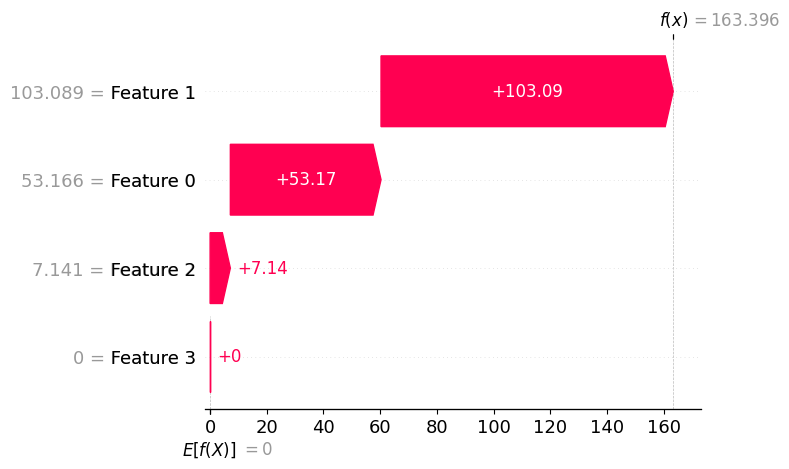

In [24]:
# Inspect the individual feature contributions (waterfall plot) for the 100th ranked individual for sharp_ranking_SCHL
individual_scores_SCHL = sharp_ranking_SCHL.individual(int(i100th[0]), X)
sharp_ranking_SCHL.plot.waterfall(individual_scores_SCHL)

plt.show()

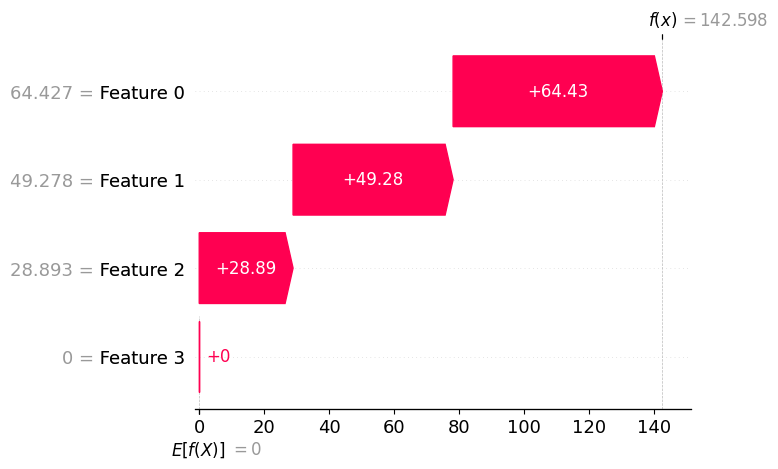

In [43]:
# Inspect the individual feature contributions (waterfall plot) for the 100th ranked individual for sharp_ranking_WKHP
individual_scores_WKHP = sharp_ranking_WKHP.individual(int(i100th[0]), X)
sharp_ranking_WKHP.plot.waterfall(individual_scores_WKHP)

plt.show()

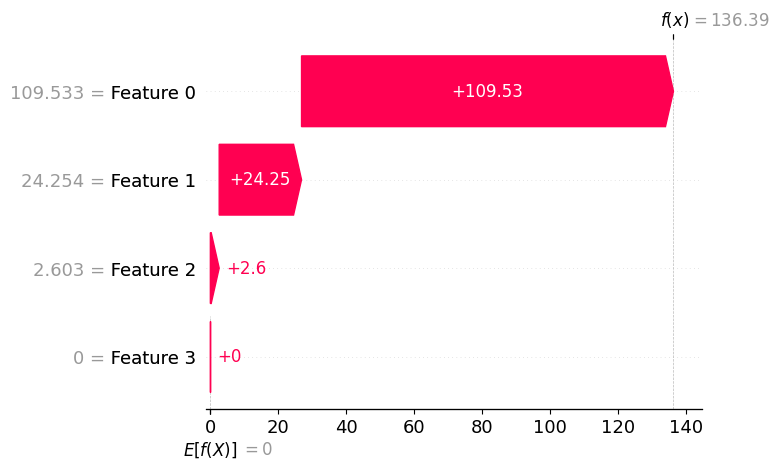

In [44]:
# Inspect the individual feature contributions (waterfall plot) for the 100th ranked individual for sharp_ranking_AGEP
individual_scores_AGEP = sharp_ranking_AGEP.individual(int(i100th[0]), X)
sharp_ranking_AGEP.plot.waterfall(individual_scores_AGEP)

plt.show()

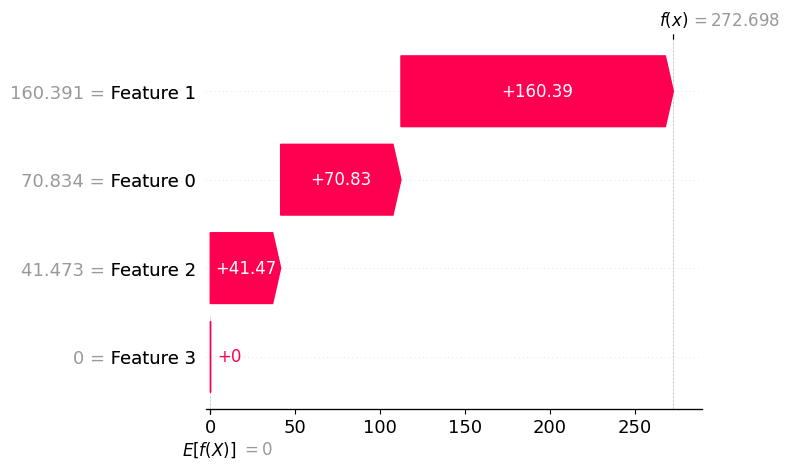

In [39]:
#Feature importance for another individual, who ranks at first position in the score_function_SCHL function.
i2_scores_SCHL = sharp_ranking_SCHL.individual(int(ifirst_SCHL[0]), X)
sharp_ranking_SCHL.plot.waterfall(i2_scores_SCHL)

plt.show()


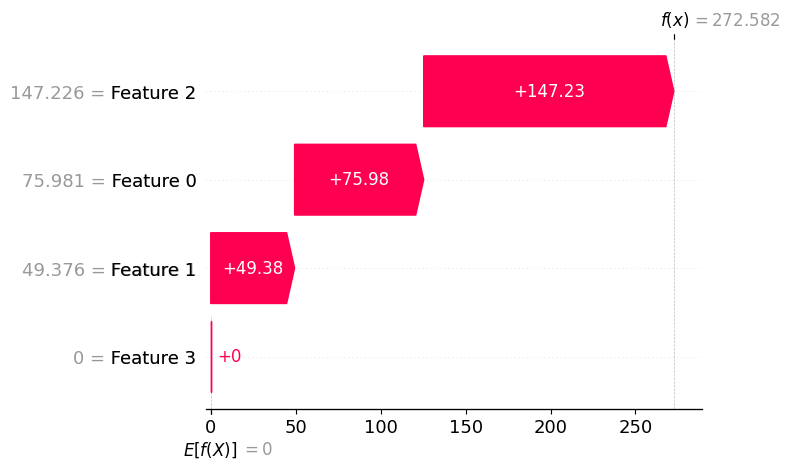

In [45]:
i2_scores_WKHP = sharp_ranking_WKHP.individual(int(ifirst_SCHL[0]), X)
sharp_ranking_WKHP.plot.waterfall(i2_scores_WKHP)

plt.show()

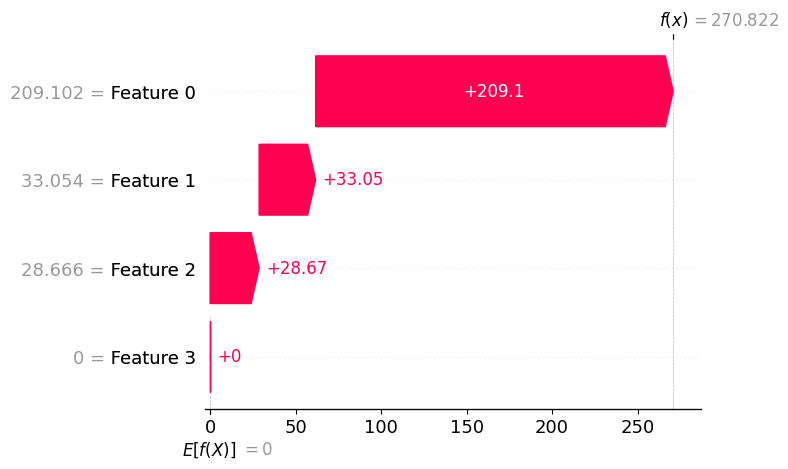

In [46]:
i2_scores_AGEP = sharp_ranking_AGEP.individual(int(ifirst_SCHL[0]), X)
sharp_ranking_AGEP.plot.waterfall(i2_scores_AGEP)

plt.show()

## TODO: Part (b)

### Part (i)

Now we will calculate the feature importances based on groups defined by the sensitive attribute. We will select one ranking function for this question and calculate the rank QoI feature importances for the top 20%.

In [27]:
# @markdown Add the rank to the dataframe
data['RANK'] = order_SCHL

data.head()

,AGEP,SCHL,WKHP,RAC1P,RANK
123170,0.363636,0.478261,0.397959,8,493
366093,0.363636,0.652174,0.397959,8,425
206601,0.515152,0.652174,0.561224,6,324
96394,0.151515,0.782609,0.500000,1,333
232318,0.393939,0.869565,0.500000,9,129


In [28]:
# # @markdown Function that will split feature explanations into different strata.
# # @markdown For this question we only look at the top 20% and plot the conributions
# # @markdown in 10% strata.

# Note that s is the ranks of the individuals (you can find this using the scores_to_ordering utility function, see Lab 8 for an example)
def make_boxplot_top20(df, X, s):
  buckets = 2
  rows = max(s)
  df['My Rank'] = s
  df['Rank Bucket'] = ["0-\n10%" if math.floor((rank - 1) / (rows / buckets)) == 0 else str(math.floor((rank - 1) / (rows / buckets)) * 10) + "-\n" + str(math.floor(((rank - 1) / (rows / buckets)) + 1) * 10) + "%" for rank in df['My Rank']]
  df.sort_values(by=['Rank Bucket'],inplace=True)
  yaxis_order = list(df.sort_values(by=['Rank Bucket'])['Rank Bucket'].unique())

  df = (
      df
      .drop(columns=["My Rank"])
      .melt(id_vars=["Rank Bucket"])
      .rename(columns={"variable": "Feature", "value": "Contribution"})
  )

  plot_df = df.copy()

  plot_df["Rank Bucket"] = plot_df["Rank Bucket"].str.replace("%", "\%").str.replace("<", "$<$")

  graph = sns.boxplot(x = plot_df['Rank Bucket'], y = plot_df['Contribution'], hue = plot_df['Feature'], palette = "Set2")
  sns.move_legend(
      graph, "lower center", bbox_to_anchor=(1, 1.05), ncol=4, title=None, frameon=False, labels=["AGEP",'WKHP',"SCHL"]
  )
  plt.setp(graph.patches, linewidth=1)
  graph.set_xlabel("Rank stratum\n(a)")

  plt.show()

Below is a usage example for this function given an X and y as they are created in this assignment:


```
# NEW
sharp_ranking_SCHL_not_white = ShaRP(
    qoi="rank",
    target_function=score_function_SCHL,
    measure="shapley",
    sample_size=None,
    replace=False,
    random_state=42,
)
X = data_non_white.drop(columns=['RAC1P', 'RANK']).to_numpy()
ranks = data_non_white['RANK'].to_numpy()
sharp_ranking_SCHL_not_white.fit(X)
df = pd.DataFrame(sharp_ranking_SCHL_not_white.all(X))
make_boxplot_top20(df,X, ranks)
```



In [29]:
# Split the top-20% into two new dataframes (white and non-white) using the race feature

In [30]:
# Create a ShaRP object for the white dataframe

In [31]:
# Create a ShaRP object for the non-white dataframe

### Part (ii)

In [32]:
# Use the make_boxplot_top20 function on each of the dataframes (see usage example above)

### Part (iii)

Inspect the plots in Part (ii)

### Part (iv)

Inspect the plots in Part (ii)

# Part (c)

Now we will try to compare the feature importance of two separate people (the 200th and the 300th). Select two samples and calculate their individual feature contributions under any QoI. Like in the question above, fix the ranking function to the first one to do so. Late visualize a way to explain why one is ranked higher than the other!

**Note:** use the full dataset (not the datasets for each race) and use the `score_function_SCHL` ranker.

In [33]:
# Select the index of the 200th ranked individual and save them in a variable called i200
# Select the index of the 300th ranked individual and save them in a variable called i300

In [34]:
# Create a waterfall plot for each of these individuals

In [35]:
# Design a new way to visualize the difference between these two individuals
# Be creative! There are no wrong answers, only incompletes :)